In [1]:
# Import our standard libraries.
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import tensorflow as tf
np.set_printoptions(precision=3, suppress=True)
from sklearn import datasets

## Importing all required libraries - in this case using GPU, verify GPU connection below:
tf.config.list_physical_devices('GPU')

2024-02-08 19:01:57.157274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 19:01:57.157299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 19:01:57.195328: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 19:01:57.275653: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 19:01:58.254137: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Iris Classification

We will train a classifier to predict 3 iris varieties from 4 features of each flower. Note: we are not doing image classification here!

![An image](flowers.png)


In [2]:
# Load the data
iris = datasets.load_iris()
X = iris.data
Y = iris.target
feature_names = iris.feature_names
class_names = iris.target_names

print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('feature names:', feature_names)
print('class names:', class_names)
print('First example:', X[0], Y[0])

"""
This cell loads the data from sci-kit learn datasets and returns basic information about its structure.
"""

X shape: (150, 4)
Y shape: (150,)
feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
class names: ['setosa' 'versicolor' 'virginica']
First example: [5.1 3.5 1.4 0.2] 0


'\nThis cell loads the data from sci-kit learn datasets and returns basic information about its structure.\n'

## Data Processing

* Shuffle
* Split into train/test
* Apply mean and variance normalization

In [3]:
np.random.seed(0)
shuffled_indices = np.random.permutation(range(len(Y)))
X = X[shuffled_indices]
Y = Y[shuffled_indices]

X_train = X[0:100]
Y_train = Y[0:100]
X_test = X[100:150]
Y_test = Y[100:150]

X_train_means = np.mean(X_train, axis=0)
X_train_stds = np.std(X_train, axis=0)
X_train = (X_train - X_train_means) / X_train_stds
X_test = (X_test - X_train_means) / X_train_stds

"""
This cell shuffles all data by randomly coming up with a parallel index
It then parces the data into 2/3 training and 1/3 test
It then applies mean / variance normalization to make the mean of all features 0 and std 1
"""

'\nThis cell shuffles all data by randomly coming up with a parallel index\nIt then parces the data into 2/3 training and 1/3 test\nIt then applies mean / variance normalization to make the mean of all features 0 and std 1\n'

## Sparse vs Dense Representation

In [4]:
# Convert Y from sparse to dense if needed
# one-hot [0, 0, 1] -> 2
# one-hot [0, 1, 0] -> 1
# one-hot [1, 0, 0] -> 0

Y_train_dense = tf.keras.utils.to_categorical(Y_train)
print(Y_train_dense.shape)
print(Y_train_dense[:6])

"""
This cell converts Y training data to a dense form using Keras' to_categorical method
"""

(100, 3)
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


"\nThis cell converts Y training data to a dense form using Keras' to_categorical method\n"

## Softmax Regression Functional Form

We will use *softmax regression*, which extends *logistic regression* to the multiclass setting. Our model will make predictions for input examples $X$ by:

\begin{align}
\hat{Y} = h_W(X) = \phi(XW^T) =
\phi\begin{pmatrix}
x_{0,0} & x_{0,1} & x_{0,2} & x_{0,3} \\
x_{1,0} & x_{1,1} & x_{1,2} & x_{1,3} \\
\vdots & \vdots & \vdots & \vdots \\
x_{m-1,0} & x_{m-1,1} & x_{m-1,2} & x_{m-1,3} \\
\end{pmatrix}
\begin{pmatrix}
w_{0,0} & w_{1,0} & w_{2,0} \\
w_{0,1} & w_{1,1} & w_{2,1} \\
w_{0,2} & w_{1,2} & w_{2,2} \\
w_{0,3} & w_{1,3} & w_{2,3} \\
\end{pmatrix}
\end{align}

A few notes about this computation:

* Our X has shape (100 x 4): 100 examples and 4 features
* Our W has shape (3 x 4): 3 classes and 4 features. The indices above are reversed because we've taken the transpose of W: the first column of $W^T$ contains the weights for the first class.
* The result will have shape (100 x 3): 3 probabilities corresponding to the 3 classes for each of the 100 examples.
* $\phi$ is the softmax function: $\frac{e^{z_i}}{\sum_j e^{z_j}}$. It is applied to the rows of $XW^T$.

More detailed background [here](http://deeplearning.stanford.edu/tutorial/supervised/SoftmaxRegression/).

### Notes
Softmax applies a function $\phi$, defined as $\frac{e^{z_i}}{\sum_j e^{z_j}}$, to our features and weights $XW^T$. This results in a probability prediction for each class for each sample.

## Softmax Normalization

In [5]:
# Remember the sigmoid function.
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Our softmax function will normalize over the rows of the input matrix.
def softmax(z):
  """z has shape (m, n): examples, classes"""
  (m, n) = z.shape

  # First exponentiate each value
  exps = np.exp(z)

  # Get the sum of each row and normalize
  row_sums = np.sum(exps, axis=1)
  for i in range(m):
    exps[i,:] /= row_sums[i]
  
  # Fancy/tricky way to do row-wise sums in numpy:
  # return np.divide(exps.T, np.sum(exps, axis=1)).T

  return exps

# Try an example.
v = np.array([[1,2,3],
              [0,2,4]])
print(softmax(v))

"""
This cell implements the softmax function. First, all values are raised to the power of e.
Then, these raised values are summed. This is the denominator of the softmax function.
Finally, the numerator (our values) are divided by this denominator iteratively
A vectorized method using the transpose of each vector is also implemented
"""

[[0.09  0.245 0.665]
 [0.016 0.117 0.867]]


'\nThis cell implements the softmax function. First, all values are raised to the power of e.\nThen, these raised values are summed. This is the denominator of the softmax function.\nFinally, the numerator (our values) are divided by this denominator iteratively\nA vectorized method using the transpose of each vector is also implemented\n'

## Making Predictions

Now, given some initial parameter values (below), compute the model's initial predictions.

In [6]:
# Initial parameter values.
# W = np.random.uniform(size=(3,4))
W = np.ones((3,4))

# Compute predictions.
preds = softmax(np.dot(X_train, W.T))
print('predictions:\n', preds[:6])
print('predictions:\n', np.argmax(preds, axis=1)[:6])
print('true labels:\n', Y_train[:6])

"""
This sell initiates weights as all equal to 1 and then makes a prediction using the softmax funciton.
The predictions are all 0 given that these weights are meaningless
"""

predictions:
 [[0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]]
predictions:
 [0 0 0 0 0 0]
true labels:
 [2 1 0 2 0 2]


'\nThis sell initiates weights as all equal to 1 and then makes a prediction using the softmax funciton.\nThe predictions are all 0 given that these weights are meaningless\n'

## Cross-Entropy Loss

We'll use the general form of *cross-entropy* loss:

\begin{align}
CrossEntropyLoss = \frac{1}{m} \sum_i \sum_j -y_j\log(\hat{y_j})
\end{align}

In this formula:

* $j$ indexes the classes (in our case [0,1,2]) and each $y$ has a dense representation like [0,0,1] which indicates class 2.
* *i* indexes over training examples, so we're computing an average loss (as usual).

## Notes
Cross entropy will be used as the loss function for gradient descent. It compares two distributions, in this case the distribution of probabilities of our class predictions compared to the actual classes, and penalizes probabilities that are far away from the real class values.

In [7]:
def ce_loss(preds, Y):
    """
    preds are (m,n) m= number of examples, n = number of classes
    Y is (m,) -- array of sparse labels
    preds[0] = [.1, .1, .8] Y[0] = 2 Y_dense[0] = [0, 0, 1]
    """
    # Get the number of examples
    m = Y.shape[0]
    
    # Compute the first sum, the cross-entropy for each example, using
    # the rows of the predictions and corresponding labels.
    # Note that we need the dense (one-hot) labels.
    Y_dense = tf.keras.utils.to_categorical(Y)
    # [.1, .1, .8] [0, 0, 1] -> [0, 0, -1*log(.8)] -> -1*log(.8)
    cross_entropy_values = - np.sum(Y_dense * np.log(preds), axis=1)

    # Here's a more efficient but tricky way to do this:
    # cross_entropy_values = -np.log(preds[range(m), Y])

    # Sum the per-example cross-entropy values.
    loss = np.sum(cross_entropy_values) / m

    return loss

#print(ce_loss(np.array([.1, .1, .8]), np.array([2])))
print(ce_loss(preds, Y_train))

"""
This cell implements cross entropy loss. Dense labels gathered, and then cross entropy is calculated.
Loss is then aclculated by taking the average of the cross entropy values.
"""

1.0986122886681093


'\nThis cell implements cross entropy loss. Dense labels gathered, and then cross entropy is calculated.\nLoss is then aclculated by taking the average of the cross entropy values.\n'

## Computing the Gradient

Again, it will turn out that the gradient computation is the same as it was for MSE with linear regression. A happy coincidence.

\begin{align}
\nabla J(W) &= \frac{1}{m}(h_W(X) - Y)^TX
\end{align}

Remember that our parameters $W$ are represented by a matrix of shape (3 x 4): 3 classes and 4 features. The gradient will include a partial derivative for every parameter, and is an average over gradients computed on each training example.

Let's review the matrix shapes:

* $h_W(X)$ is (100 x 3): 3 probabilities for each example.
* $Y$ is (100 x 3): this is the dense (one-hot) version of the labels, matching the shape of the predictions.
* $X$ is (100 x 4): 4 features for each example.
* The resulting product is (3 x 100)(100 x 4), giving a (3 x 4) output, which matches the shape of our parameters $W$.


In [8]:
# y' = [.1, .2, .7]  y = [0, 0, 1]  diff = y' - y = [.1, .2, -.3]
# d1 = [.1, .2, -.3]  x1 = [1, 2, 3, 4]
# (3 x 100) (100 x 4) -> (3 x 4)
# [ [ .1*1,  .1*2,  .1*3,  .1*4 ]
#   [ .2*1,  .2*2,  .2*3,  .2*4 ]
#   [-.3*1, -.3*2, -.3*3, -.3*4 ]
# ]
#
# We need the dense version of Y here
m = Y_train.shape[0]
Y_train_dense = tf.keras.utils.to_categorical(Y_train)
diff = preds - Y_train_dense
gradient = np.dot(diff.T, X_train) / m
print('gradient:\n', gradient)

"""
This cell shows an example of calculating the gradient by taking the dot product of
the differences tranposed and the training data, and then dividing that by the number of samples
"""

gradient:
 [[ 0.337 -0.28   0.431  0.411]
 [-0.042  0.191 -0.089 -0.046]
 [-0.295  0.09  -0.342 -0.365]]


'\nThis cell shows an example of calculating the gradient by taking the dot product of\nthe differences tranposed and the training data, and then dividing that by the number of samples\n'

In [9]:
# Simplify and just compute the gradient for the first training example.
print(diff[0:1].T)
print(X_train[0:1])
print('gradient:\n', np.dot(diff[0:1].T, X_train[0:1]))

"""
This cell shows examples of the gradient calculation for the first sample
"""

[[ 0.333]
 [ 0.333]
 [-0.667]]
[[-0.017 -0.543  0.76   1.567]]
gradient:
 [[-0.006 -0.181  0.253  0.522]
 [-0.006 -0.181  0.253  0.522]
 [ 0.011  0.362 -0.507 -1.045]]


'\nThis cell shows examples of the gradient calculation for the first sample\n'

## Running Gradient Descent

Let's put together the code for a single gradient descent step:

In [10]:
# Run gradient descent
m, n = X.shape # m = number of examples; n = number of features(including bias)
learning_rate = 0.01

for _ in range(1000):
    preds = softmax(np.dot(X_train, W.T))
    loss = ce_loss(preds, Y_train)
    gradient = np.dot((preds - tf.keras.utils.to_categorical(Y_train)).T, X_train) / m
    W = W - learning_rate * gradient

print('labels:\n', Y_train[:6])
print('predictions:\n', preds[:6])
print('loss:', loss)
print('gradient:\n', gradient)
print('weights:\n', W)

"""
This cell implements gradient descent for 1000 epochs and a learning rate of 0.01 interatively.
"""

labels:
 [2 1 0 2 0 2]
predictions:
 [[0.025 0.201 0.774]
 [0.084 0.673 0.243]
 [0.99  0.006 0.003]
 [0.007 0.154 0.838]
 [0.962 0.032 0.006]
 [0.014 0.081 0.905]]
loss: 0.43657251861677077
gradient:
 [[ 0.012 -0.026  0.026  0.023]
 [-0.01   0.026 -0.007  0.01 ]
 [-0.001 -0.    -0.018 -0.033]]
weights:
 [[0.539 1.556 0.295 0.347]
 [1.08  0.492 1.132 0.922]
 [1.381 0.951 1.573 1.731]]


'\nThis cell implements gradient descent for 1000 epochs and a learning rate of 0.01 interatively.\n'

## Evaluation

In [11]:
# Make predictions on the test data
test_preds = softmax(np.dot(X_test, W.T))
test_pred_labels = np.argmax(test_preds, axis=1)
print('Accuracy:', np.mean(test_pred_labels == Y_test))

"""
This cell takes the weights from gradient descent and applies them to the softmax function to make
predictions on test data. It returns an accuracy score.
"""

Accuracy: 0.84


'\nThis cell takes the weights from gradient descent and applies them to the softmax function to make\npredictions on test data. It returns an accuracy score.\n'

2024-02-08 19:01:59.580003: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-08 19:01:59.580212: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-08 19:01:59.580367: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

'\nThis cell plots a confusion matrix of the previous example.\n'

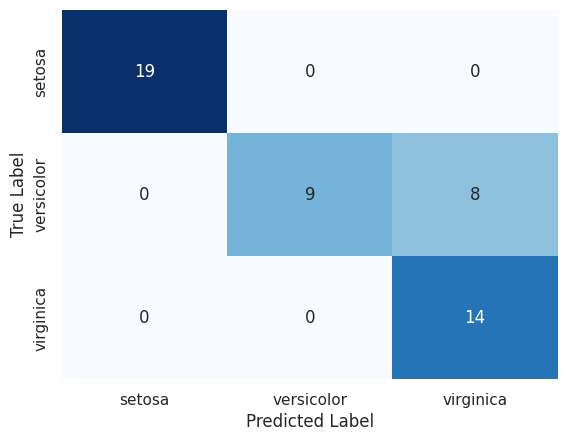

In [12]:
cf = tf.math.confusion_matrix(Y_test, test_pred_labels)
ax = sns.heatmap(cf, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names, cbar=False)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show

"""
This cell plots a confusion matrix of the previous example.
"""

## Now with TensorFlow/Keras

In [13]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(
    units=3,                    # output dim
    input_shape=[4],            # input dim
    use_bias=False,             # we included the bias in X
    activation='softmax',      # apply a sigmoid to the output
    kernel_initializer=tf.ones_initializer, # initialize params to 1
))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

"""
This cell sets up our one layer keras model for multiclass logisitic regression.
"""

'\nThis cell sets up our one layer keras model for multiclass logisitic regression.\n'

In [14]:
# As above, get predictions for the current model first.
preds = model.predict(X)

# Do a single gradient update.
history = model.fit(
    x = X_train,
    y = Y_train,
    epochs=100,
    batch_size=10,
    verbose=0
)

# Show the loss (before the update) and the new weights.
loss = history.history['loss'][0]
weights = model.layers[0].get_weights()[0].T
print('predictions:\n', preds[:6])
print('loss:', loss)
print('W:\n', weights)

"""
This cell fits the model for 100 epochs and a batch size of 10.
It then prints out the predictions for the first 6 samples, the loss, and the final weights.
"""

5/5 [==============================] - 0s 948us/step


2024-02-08 19:02:00.622802: I external/local_xla/xla/service/service.cc:168] XLA service 0x76a2f591b560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-08 19:02:00.622818: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-02-08 19:02:00.630555: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-08 19:02:00.649546: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1707436920.713275    6778 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


predictions:
 [[0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]
 [0.333 0.333 0.333]]
loss: 0.990375280380249
W:
 [[ 0.257  2.901 -0.779 -0.707]
 [ 1.626 -0.311  2.092  0.157]
 [ 1.228  0.609  2.049  2.974]]


'\nThis cell fits the model for 100 epochs and a batch size of 10.\nIt then prints out the predictions for the first 6 samples, the loss, and the final weights.\n'

In [15]:
print(history.history['loss'])

[0.990375280380249, 0.7967755794525146, 0.6771520972251892, 0.5968527793884277, 0.5492150783538818, 0.5157124996185303, 0.493833988904953, 0.4753832519054413, 0.4632093906402588, 0.45182713866233826, 0.4425351619720459, 0.4349922239780426, 0.42973342537879944, 0.4224408268928528, 0.41705211997032166, 0.41252875328063965, 0.40790805220603943, 0.4042285084724426, 0.40097999572753906, 0.3972621560096741, 0.394033819437027, 0.39123666286468506, 0.3888702392578125, 0.38593590259552, 0.38395756483078003, 0.382277250289917, 0.37955406308174133, 0.377309650182724, 0.37643375992774963, 0.37366122007369995, 0.3739987313747406, 0.3705388009548187, 0.36934810876846313, 0.3678604066371918, 0.367064505815506, 0.3652578592300415, 0.36418837308883667, 0.3628968298435211, 0.36233651638031006, 0.36071503162384033, 0.3599056899547577, 0.3591265380382538, 0.3583102524280548, 0.3577701449394226, 0.35645174980163574, 0.35584911704063416, 0.3553796708583832, 0.3546454608440399, 0.35383617877960205, 0.3533016

In [16]:
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)
accuracy = np.mean(test_preds_labels == Y_test)
print(accuracy)
model.evaluate(x=X_test, y=Y_test)

2/2 [==============================] - 0s 1ms/step


0.9
2/2 [==============================] - 0s 3ms/step - loss: 0.2554


0.25537192821502686